In [1]:
import numpy as np
import librosa
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
from tqdm import tqdm
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.metrics import recall_score

# Load Data
# audios = pd.read_csv("/content/drive/MyDrive/SPOG/Audio_Clips_Balanced.csv")
# audios = pd.read_csv("/content/drive/MyDrive/SPOG/private_metadata.csv")
# audios = pd.read_csv("/content/drive/MyDrive/SPOG/BAB.csv")

# Update label mapping for 5 labels
label_mapping = {'Canonical': 0, 'Non-canonical': 1, 'Crying': 2, 'Junk': 3, 'Laughing': 4}

#filter out nan
# audios.dropna(inplace = True)

#drop columns
# to_drop = ['child_ID', 'age_mo_round', 'child_gender']
# audios.drop(columns=to_drop, inplace=True)

# Function to get mel spectrogram
def get_melspectrogram_db(file_path, sr=None, target_sr=16000, n_fft=1600, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav, sr = librosa.load(file_path, sr=sr)

    # change to mono
    if len(wav.shape) > 1:
        wav = librosa.to_mono(wav)

    # resample to 16000
    wav_resampled = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)

    # if wav.shape[0] < 0.5 * sr:
    #     wav = np.concatenate([wav, wav[-1].repeat(int(0.5 * sr) - wav.shape[0])])

    mel_spec = librosa.feature.melspectrogram(y=wav_resampled, sr=sr, n_fft=n_fft,
                                           hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max, top_db=top_db)
    return mel_spec_db

# Function to convert spectrogram to image
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled



In [2]:
def plot_spectrogram(spec):
    plt.figure(figsize=(10, 4))
    plt.imshow(spec, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel Bin')
    plt.tight_layout()
    plt.show()

In [3]:
# Define Dataset Class
class AudioArrays(Dataset):
    def __init__(self, base, df, in_col, out_col, frames_per_second=128, max_duration=0.5):
        self.df = df
        self.data = []
        self.labels = []
        self.frames_per_second = frames_per_second
        self.max_frames = int(frames_per_second * max_duration)

        self.label_mapping = label_mapping

        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base, row[in_col])
            spec = spec_to_image(get_melspectrogram_db(file_path))[np.newaxis, ...]

            # Pad or truncate the spectrogram to the target number of frames
            if spec.shape[2] < self.max_frames:
                leftover = self.max_frames - spec.shape[2]
                half = leftover // 2

                if leftover % 2 == 0:
                    spec = np.pad(spec, ((0, 0), (0, 0), (half, half)), mode='edge')
                else:
                    spec = np.pad(spec, ((0, 0), (0, 0), (half + 1, half)), mode='edge')

            label = self.label_mapping[row[out_col]]
            # Convert label to one-hot encoding
            one_hot_label = np.zeros(len(label_mapping))
            one_hot_label[label] = 1
            self.data.append(spec)
            self.labels.append(np.float32(one_hot_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx], dtype=torch.float32)

#might want to set a random seed here

# Set prefix for file paths
prefix = '/content/drive/MyDrive/SPOG/BabbleCor_clips/'

# Split dataset into train and validation
# train_size = int(0.8 * len(audios))
# valid_size = len(audios) - train_size
# train, valid = random_split(audios, [train_size, valid_size])

train = pd.read_csv('/content/drive/MyDrive/SPOG/babblecor_train.csv')
valid = pd.read_csv('/content/drive/MyDrive/SPOG/babblecor_test.csv')

# Create datasets and data loaders
train_dataset = AudioArrays(prefix, train, 'audio_file', 'label', frames_per_second=128, max_duration=0.5)
valid_dataset = AudioArrays(prefix, valid, 'audio_file', 'label', frames_per_second=128, max_duration=0.5)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)


# Create datasets and data loaders
# audios_dataset = AudioArrays(prefix, audios, 'clip_ID', 'Answer', frames_per_second=128, max_duration=0.5)
# train_dataset, valid_dataset = random_split(audios_dataset, [train_size, valid_size])

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

 28%|██▊       | 1134/3996 [09:45<15:31,  3.07it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1600 is too large for input signal of length=1536
  warnings.warn(
 34%|███▍      | 1371/3996 [11:04<14:28,  3.02it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1600 is too large for input signal of length=1104
  warnings.warn(
 53%|█████▎    | 2104/3996 [15:09<11:16,  2.80it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1600 is too large for input signal of length=1344
  warnings.warn(
 92%|█████████▏| 3696/3996 [23:59<01:39,  3.01it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1600 is too large for input signal of length=944
  warnings.warn(
  2%|▏         | 74/3691 [00:25<19:12,  3.14it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1600 is too large for input signal 

In [4]:
# Load Pre-trained ResNet model
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,5)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 136MB/s]


In [5]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # Binary cross-entropy loss for one-hot encoded labels
learning_rate = 0.0001
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 10

# Training loop
for epoch in range(epochs):
  resnet_model.train()
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)

    optimizer.zero_grad()

    outputs = resnet_model(inputs)
    loss = loss_fn(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)

  epoch_loss = running_loss / len(train_loader.dataset)
  print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")

  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
        outputs = resnet_model(inputs)
        # predicted = torch.round(torch.sigmoid(outputs))  # Round to get binary predictions
        # predicted = (outputs >= 0).float()
        probabilities = torch.softmax(outputs, dim=1)
        threshold = 0.5

        # Convert probabilities to binary predictions
        predicted = (probabilities >= threshold).float()
        total += labels.size(0)
        correct += (predicted == labels).all(dim=1).sum().item()
    print(f"Accuracy on validation set: {(correct / total) * 100}%")

  # resnet_model.eval()
  # all_labels = []
  # all_predicted = []

  # with torch.no_grad():
  #   for inputs, labels in valid_loader:
  #     inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
  #     outputs = resnet_model(inputs)
  #     probabilities = torch.softmax(outputs, dim=1)
  #     threshold = 0.5

  #     # Convert probabilities to binary predictions
  #     predicted = (probabilities >= threshold).float()

  #     all_labels.extend(labels.cpu().numpy())
  #     all_predicted.extend(predicted.cpu().numpy())

  # # Convert lists to numpy arrays
  # all_labels = np.array(all_labels)
  # all_predicted = np.array(all_predicted)

  # # Compute recall for each class
  # recall_per_class = recall_score(all_labels, all_predicted, average=None)

  # # Compute UAR
  # uar = np.mean(recall_per_class)

  # print(f"Unweighted Average Recall (UAR) on validation set: {uar * 100}%")

Epoch 1/10, Loss: 1.0072850951322683
Accuracy on validation set: 53.481441343809266%
Epoch 2/10, Loss: 0.7729934450384375
Accuracy on validation set: 57.05770793822812%
Epoch 3/10, Loss: 0.6438110872909233
Accuracy on validation set: 60.30885938769981%
Epoch 4/10, Loss: 0.49661515914164744
Accuracy on validation set: 58.27688973178%
Epoch 5/10, Loss: 0.3659282207518846
Accuracy on validation set: 58.43944730425359%
Epoch 6/10, Loss: 0.28758998925949597
Accuracy on validation set: 60.71525331888377%
Epoch 7/10, Loss: 0.21209335135476845
Accuracy on validation set: 60.93199674884855%
Epoch 8/10, Loss: 0.17847580190102855
Accuracy on validation set: 62.90978054727716%
Epoch 9/10, Loss: 0.11312911569796226
Accuracy on validation set: 59.82118667027906%
Epoch 10/10, Loss: 0.14145961542939162
Accuracy on validation set: 62.25955025738282%


In [6]:
# # Testing loop
# resnet_model.eval()
# correct = 0
# total = 0
# all_labels = []
# all_predicted = []

# with torch.no_grad():
#     for inputs, labels in valid_loader:
#         inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
#         outputs = resnet_model(inputs)
#         # predicted = torch.round(torch.sigmoid(outputs))  # Round to get binary predictions
#         # predicted = (outputs >= 0).float()
#         probabilities = torch.softmax(outputs, dim=1)
#         threshold = 0.5

#         # Convert probabilities to binary predictions
#         predicted = (probabilities >= threshold).float()
#         # print(predicted)
#         total += labels.size(0)
#         correct += (predicted == labels).all(dim=1).sum().item()
#         # print((predicted == labels).all(dim=1).sum().item()
#         # # print(total)
#         # print(f"label: {labels}\n")
#         # print(f"predicted: {predicted}\n")
#         # print("---------")
#         all_labels.extend(labels.cpu().numpy())
#         all_predicted.extend(predicted.cpu().numpy())


# print(f"Accuracy on validation set: {(correct / total) * 100}%")

# Testing loop
resnet_model.eval()
all_labels = []
all_predicted = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
        outputs = resnet_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        threshold = 0.5

        # Convert probabilities to binary predictions
        predicted = (probabilities >= threshold).float()

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predicted = np.array(all_predicted)

# Compute recall for each class
recall_per_class = recall_score(all_labels, all_predicted, average=None)

# Compute UAR
uar = np.mean(recall_per_class)

print(f"Unweighted Average Recall (UAR) on validation set: {uar * 100}%")


Unweighted Average Recall (UAR) on validation set: 44.136415503133335%


In [ ]:
arrays_with_multiple_ones = np.any(np.sum(all_predicted, axis=1) > 1)

if arrays_with_multiple_ones:
    print("There are arrays with more than one '1'.")
    print(f"{np.sum(np.sum(all_predicted, axis=1) > 1)}")
else:
    print("All arrays have at most one '1'.")


All arrays have at most one '1'.


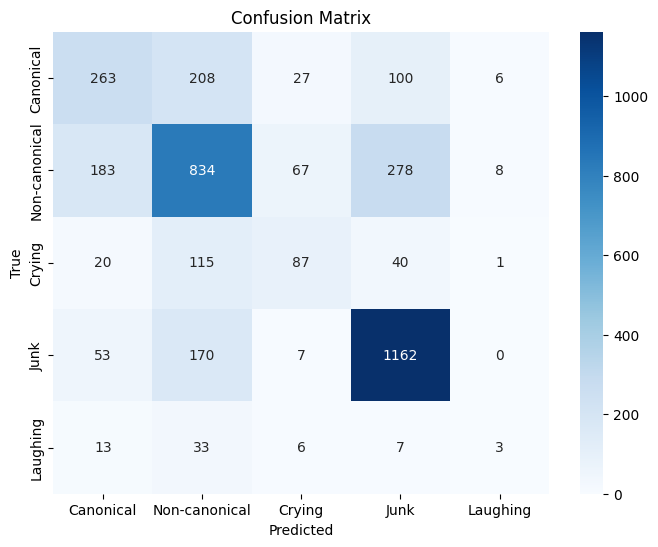

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'true_labels' are the true labels and 'predicted_labels' are the predicted labels
# You need to convert them from tensors to numpy arrays for use with confusion_matrix
true_labels = np.argmax(all_labels, axis=1)
predicted_labels = np.argmax(all_predicted, axis = 1)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels (replace with your actual class labels)
class_labels = ['Canonical', 'Non-canonical', 'Crying', 'Junk', 'Laughing']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


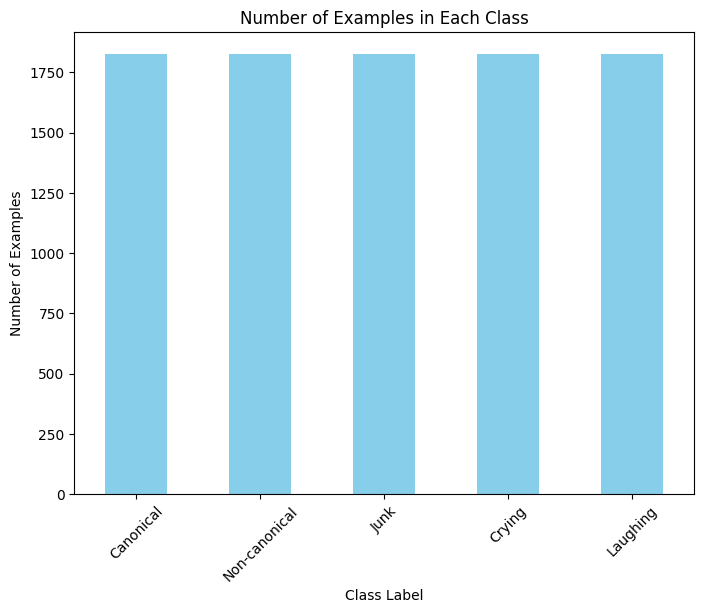

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame (replace this with your actual DataFrame)
# audios = pd.DataFrame({'Label': ['Canonical', 'Non-canonical', 'Crying', 'Junk', 'Laughing', 'Canonical', 'Crying', 'Junk', 'Laughing']})

# Get the counts of each label
label_counts = audios['Label'].value_counts()

# Plot the bar plot
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Examples')
plt.title('Number of Examples in Each Class')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
